In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sns
from itertools import product
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
import umap.umap_ as umap
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
import GEOparse

# data cleaning (could be improved)

In [2]:
geo_expr = pd.read_csv("GSE209998_AUR_129_UQN.txt.gz",sep='\t')
gse = GEOparse.get_GEO(geo="GSE209998", destdir="./")


19-Mar-2024 22:27:26 DEBUG utils - Directory ./ already exists. Skipping.
19-Mar-2024 22:27:26 INFO GEOparse - File already exist: using local version.
19-Mar-2024 22:27:26 INFO GEOparse - Parsing ./GSE209998_family.soft.gz: 
19-Mar-2024 22:27:26 DEBUG GEOparse - DATABASE: GeoMiame
19-Mar-2024 22:27:26 DEBUG GEOparse - SERIES: GSE209998
19-Mar-2024 22:27:26 DEBUG GEOparse - PLATFORM: GPL16791
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412478
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412479
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412480
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412481
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412482
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412483
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412484
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412485
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412486
19-Mar-2024 22:27:26 DEBUG GEOparse - SAMPLE: GSM6412487
19-Mar-2024 22:27:26 DEBUG GEOpars

In [3]:
geo_expr = geo_expr.set_index('Unnamed: 0')
geo_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
DDX11L1,226.295552,9.364527,81.828101,1.732418e+02,55.411001,70.594612,189.713027,71.952983,129.128416,106.350359,...,5.423877,1.080000e-08,16.470347,13.339344,180.028771,24.464645,18.898216,0.000000,20.889980,0.029141
WASH7P,278.062337,458.132967,920.758358,1.410917e+03,1099.043609,511.626830,2557.589429,1384.932636,1178.785410,1077.756317,...,1035.572218,1.718968e+03,1022.557983,879.090069,3590.402236,1186.907358,1091.301708,351.168479,602.536170,881.767243
MIR6859-3,0.000000,0.243191,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-34P13.3,0.000000,0.996507,2.524623,0.000000e+00,4.986191,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.921808e+00,0.000000,0.000000,0.000000,1.761520,0.000000,0.000000,0.000000,0.000000
MIR1302-9,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,1558.240459,1768.481325,23444.715010,1.110826e+06,107176.339900,4980.868489,28034.970640,4739.375568,9587.406146,5090.115751,...,1264.980886,1.287495e+03,472.285504,2460.446112,3787.626875,8834.800789,3035.175840,2962.858772,2046.919853,2698.422044
MT-TE,0.000000,1.945524,12.958967,3.518182e+01,8.737356,2.040537,10.678057,12.578027,1.915198,28.451139,...,0.000000,0.000000e+00,0.000000,22.336764,2.061855,9.911893,5.393519,4.285717,3.225206,0.000000
MT-CYB,30424.909610,50881.775800,98926.377670,2.247651e+06,273394.925900,69023.398820,263486.385500,26800.002980,88531.957210,84519.282440,...,46556.853130,3.191926e+04,14174.108370,20379.719920,16008.239010,88979.065090,40603.759280,101565.055900,46191.397220,53846.878370


In [4]:
geo_clin_matrix= gse.phenotype_data.copy()

geo_clin_matrix['sample_id'] = [tit.split(' ')[-1][1:-1] for tit in geo_clin_matrix.title]
geo_clin_matrix['patient_id'] = [pat.split('-')[1] for pat in geo_clin_matrix.sample_id]

In [231]:
#geo_clin_matrix.to_csv('AURORA_dataset_clinical_matrix.csv')

In [5]:
common_samps=geo_expr.columns.intersection(geo_clin_matrix['sample_id'])
geo_expr = geo_expr[common_samps]
geo_clin_matrix = geo_clin_matrix[geo_clin_matrix.sample_id.isin(common_samps)]

In [29]:
geo_clin_matrix['characteristics_ch1.3.treatment'].value_counts()


Metastasis        79
Pre-treatment     26
Post-treatment    17
Normal tissue      6
Unknown            1
Name: characteristics_ch1.3.treatment, dtype: int64

In [234]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['characteristics_ch1.3.treatment'].value_counts()

Pre-treatment     26
Post-treatment    17
Unknown            1
Name: characteristics_ch1.3.treatment, dtype: int64

In [235]:
#liver has two different normal tissue samples. check dates probably remove duplicates
geo_clin_matrix[geo_clin_matrix.columns[geo_clin_matrix.columns.str.contains("characteristics")]]


,characteristics_ch1.0.disease,characteristics_ch1.1.tissue,characteristics_ch1.2.genotype,characteristics_ch1.3.treatment,characteristics_ch1.4.time
GSM6412478,Primary tumor,Breast,Female,Pre-treatment,Autopsy
GSM6412479,Metastatic tumor,Lymph node,Female,Metastasis,Autopsy
GSM6412480,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412481,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412482,Metastatic tumor,Lung,Female,Metastasis,Autopsy
...,...,...,...,...,...
GSM6412602,Normal tissue,Brain,Female,Normal tissue,Autopsy
GSM6412603,Normal tissue,Lung,Female,Normal tissue,Autopsy
GSM6412604,Normal tissue,Liver,Female,Normal tissue,Autopsy
GSM6412605,Normal tissue,Breast,Female,Normal tissue,Non-Autopsy


In [236]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['patient_id'].value_counts()

AF94    1
AER6    1
AD9J    1
AFSO    1
AFEC    1
AF98    1
AERX    1
AFEA    1
AFKB    1
AE6Y    1
AERW    1
AG0J    1
AER4    1
AG0N    1
AFR4    1
AFR5    1
AFSP    1
AFUM    1
AFE7    1
AE5H    1
AFE4    1
AFUN    1
AFR3    1
AFUL    1
AF9A    1
AER2    1
AFR2    1
AF95    1
AFKF    1
AE5G    1
AER7    1
AFE6    1
AG12    1
AFUI    1
AEPZ    1
AD9G    1
AFUO    1
AE6X    1
AFKD    1
AFE5    1
AFSL    1
AFE9    1
AG0M    1
AER8    1
Name: patient_id, dtype: int64

In [237]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['patient_id'].value_counts()

AER6    8
AFEA    5
AFE9    4
AD9E    3
AFE4    3
AFEC    3
AFE7    3
AD9H    3
AD9F    3
AFUK    2
AD9G    2
AFE5    2
AFE6    2
AER2    2
AFKB    1
AERX    1
AE6Y    1
AERW    1
AF94    1
AERY    1
AG0J    1
AFUG    1
AG0N    1
AFR4    1
AFR5    1
AFSP    1
AFUM    1
AE5H    1
AF98    1
AFUL    1
AFSO    1
AFUN    1
AF95    1
AFKF    1
AE5G    1
AER7    1
AG12    1
AF9A    1
AFUI    1
ADCB    1
AE6X    1
AFUP    1
AFSL    1
AD9I    1
AG0M    1
AEPZ    1
AFR3    1
AER8    1
Name: patient_id, dtype: int64

In [238]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['characteristics_ch1.1.tissue'].value_counts()


Liver          18
Lymph node     11
Brain           9
Lung            8
Chest           7
Soft tissue     4
Pleura          3
Ovary           3
Skin            3
Adrenal         3
Bone            2
Thyroid         1
Pericardium     1
Stomach         1
Peritoneum      1
Uterus          1
Rectum          1
Diaphragm       1
Spleen          1
Name: characteristics_ch1.1.tissue, dtype: int64

In [30]:
unwanted_itg=['ITGB3BP','ITGB1BP1','ITGA9-AS1','ITGB5-AS1','ITGB1P1','ITGB2-AS1','ITGB1BP2']
geo_expr=geo_expr.loc[~geo_expr.index.isin(unwanted_itg)]
itg_expr = geo_expr.loc[geo_expr.index.str.contains('ITG')]
itg_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ITGA10,526.184054,532.100428,1071.274167,1271.570476,1096.538609,506.054206,1110.518153,817.572033,1187.422980,601.354404,...,437.577404,473.691646,350.334314,342.783625,548.452701,360.132119,1573.559702,284.285871,604.188335,865.625992
ITGB6,1117.205454,2977.621990,3038.881393,3714.196467,4486.631845,3532.161680,1324.080160,1236.420018,762.249082,435.820295,...,857.790397,3695.745769,1829.274950,3067.866508,0.000000,8.810572,2437.864971,10.000005,10546.422590,6334.380583
ITGA6,5234.329963,7648.563655,11939.139490,10421.342150,9111.394211,6956.973478,54260.822130,154421.090900,93665.113860,53207.021740,...,6088.671462,7408.396466,8736.370876,7663.139329,1365.175365,4687.819418,4133.613363,1598.436993,18794.201230,16912.473680
ITGA4,2543.639052,709.143511,1015.119853,623.221157,1563.985886,6782.750760,1089.161532,1347.107087,944.193745,603.939875,...,388.958198,406.427231,2893.580233,4024.911153,43.298884,134.361472,2537.649967,650.000657,1671.731266,1182.812996
ITGAV,6384.779426,8354.222451,19922.910950,11200.281860,16038.556420,9590.138368,22124.357100,45612.431140,28540.026170,15266.626890,...,11017.357410,12038.078050,11174.245240,24672.542720,5580.371891,16656.758300,11719.032920,4174.903882,9197.921477,18262.409420
ITGA9,3077.303897,2244.747801,1510.554593,3573.031929,2834.876642,3223.091175,4268.550187,5045.051985,3797.761168,2760.498309,...,4115.070336,1656.976467,3757.136394,2250.822548,1470.102320,1110.918049,5500.753062,3062.332899,2818.553013,3149.801994
ITGB5,2349.126338,3873.538215,3846.646436,6624.237560,3709.008214,1281.458503,7365.190256,11111.426540,5963.921073,3588.725977,...,5692.847977,10666.595650,7117.543608,17422.637110,6967.015162,1731.271847,5802.080203,6361.427656,4381.980902,11623.440730
ITGA1,10719.564430,4823.421850,2893.629841,1672.505760,8000.447789,9551.699407,6717.067272,6401.228823,3925.167533,3467.946843,...,9850.667227,7424.163368,7681.185692,6791.593725,258.231885,1928.480691,21788.797450,23190.206680,8996.654725,13502.024050
ITGA2,2251.868248,1928.991238,3330.465298,1120.789993,5355.999200,3870.898262,6735.188468,6017.334094,4814.810475,4346.563070,...,3125.552366,3475.949966,2426.835403,5966.496955,321.649109,4213.652620,3206.443219,207.142971,7920.027754,7268.754986


# other stuff

In [31]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']!='Post-treatment'].copy()
#dropping metastatic tissue from brain b/c brain is different from other ones
temp_info_sample = temp_info_sample[~((temp_info_sample.source_name_ch1=='Metastatic tumor') & (temp_info_sample['characteristics_ch1.1.tissue']=='Brain'))]
#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [256]:
#looking at some correlations
#only primary tumor samples
primtum_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[primtum_temp_info_sample['sample_id']].T,
                                                          rowvar=False),
                                          columns=geo_expr[primtum_temp_info_sample['sample_id']].T.columns,
                                              index=geo_expr[primtum_temp_info_sample['sample_id']].T.columns)
#only metastatic tumor samples
met_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[met_temp_info_sample['sample_id']].T,
                                                          rowvar=False),
                                          columns=geo_expr[met_temp_info_sample['sample_id']].T.columns,
                                              index=geo_expr[met_temp_info_sample['sample_id']].T.columns)




/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [91]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')


In [ ]:
%%time

fig,axs=plt.subplots(nrows=int(itg_expr.index.values.shape[0]/3),
                     ncols=int(itg_expr.index.values.shape[0]/9),
                     figsize=(15,30))

for ax, gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):

    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=15)
    ax.tick_params(axis='y', labelsize=15)      

    ax.set_ylabel(gene_chosen,fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)

# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





/home/hshadman/.local/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 14.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/hshadman/.local/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


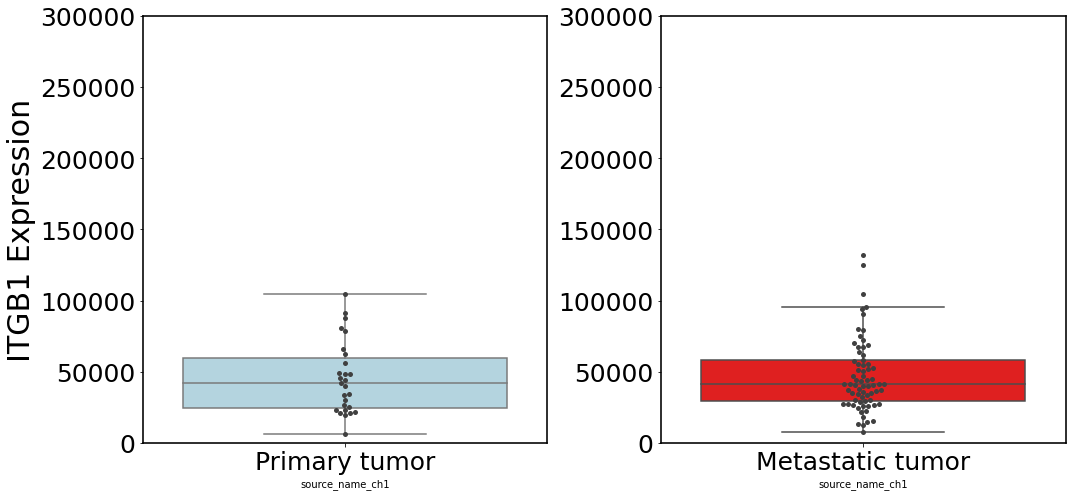

In [63]:
#practice for below cell
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,7))


#ylim_min = 0
#ylim_max = 300000
gene_chosen = 'ITGB1'
sns.boxplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='lightblue',
                      ax=ax[0],showfliers=False)
sns.swarmplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='.25',
                      ax=ax[0])

plt.setp(ax[0].get_xticklabels(),fontsize=25)
ax[0].tick_params(axis='y', labelsize=25)      
#ax[0].set_xlabel('Primary Tumor',fontsize=30)
ax[0].set_ylabel(gene_chosen+' Expression',fontsize=30)
ax[0].set_ylim(ylim_min,ylim_max)
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)


sns.boxplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='red',
                       ax=ax[1],showfliers=False)
sns.swarmplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='.25',
                       ax=ax[1])
plt.setp(ax[1].get_xticklabels(),fontsize=25)
ax[1].tick_params(axis='y', labelsize=25)      
ax[1].set_ylim(ylim_min,ylim_max)
#ax[1].set_xlabel('Metastatic Tumor',fontsize=30)
#ax[1].set_ylabel(gene_chosen+' Expression',fontsize=30)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





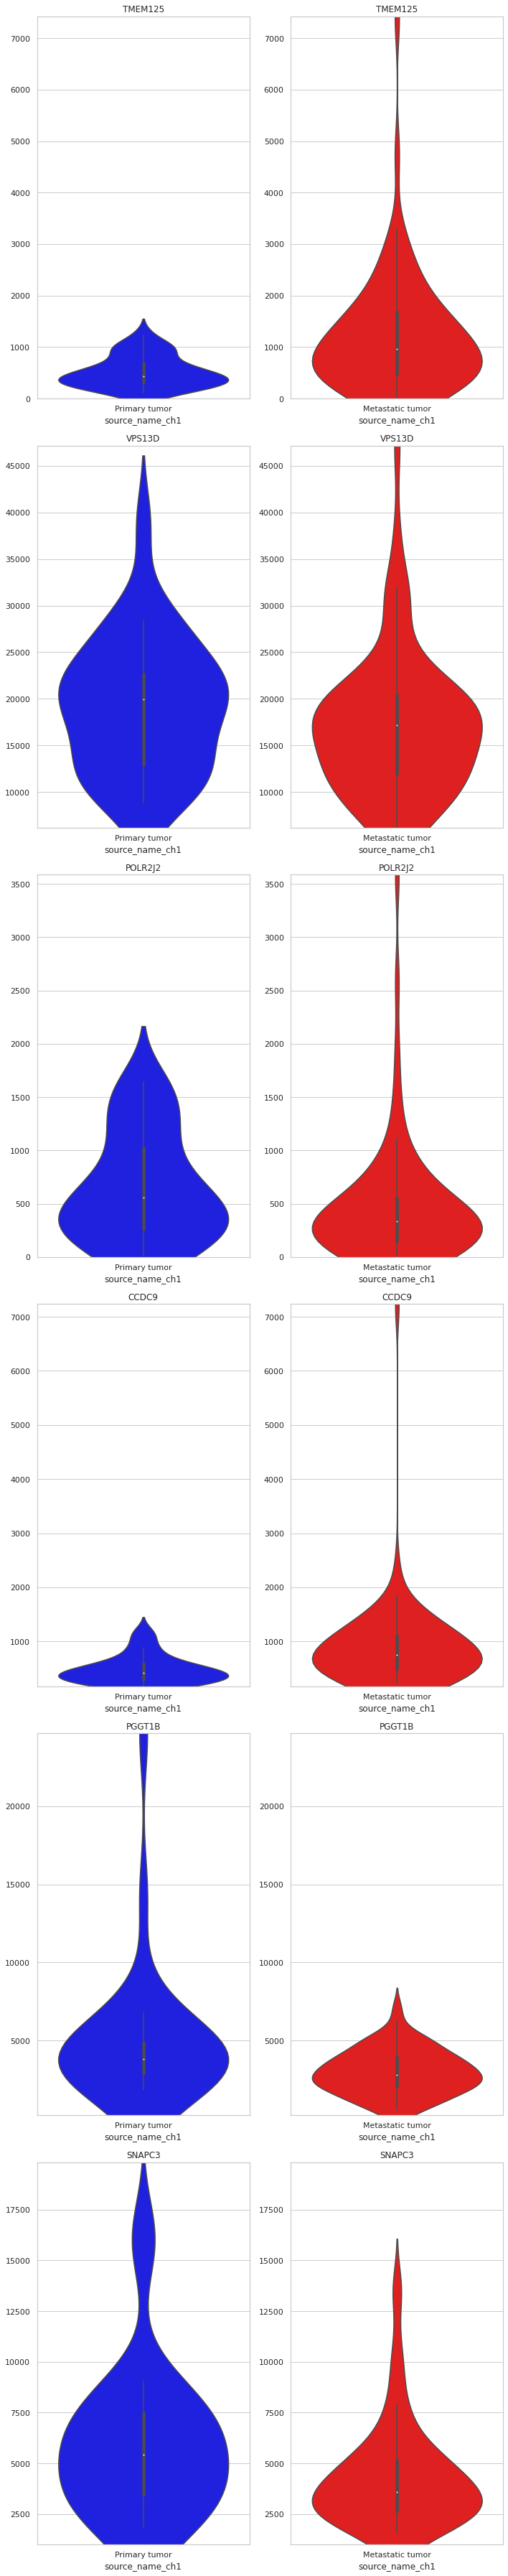

In [222]:
#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#downregulated_missing ='AC010422.5'
#JUST looking at downregulated from the CTC signature list for normoxia vs hypoxia
donato_downregulated = ['TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
nrows = len(donato_downregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,50))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for downreg_gene_prim,downreg_gene_met in zip(donato_downregulated,donato_downregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[downreg_gene_prim].max()
    min_lim=geo_expr.loc[downreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[downreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(downreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[downreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(downreg_gene_met) 
    j+=1
    

plt.tight_layout()



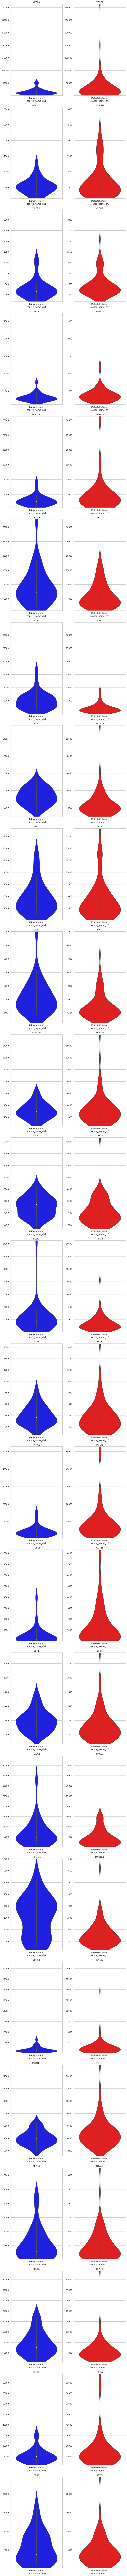

In [223]:

#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#upregulated_missing ='AC010422.5'
#JUST looking at upregulated from the CTC signature list for normoxia vs hypoxia

donato_upregulated = ['VEGFA','UBALD1','CLCN2','ZNF771','FAM13A','ABCC5','IKZF2','ZBTB43','IRS1',
                       'BIVM','PIK3C2B','LRIG2','MLLT3','PLD6','P4HA1','GDF15','LIPT1','MACC1','PPP1R3E',
                       'EPHX2','POFUT1','NIPAL1','CCNG2','HIF1A','CTSS']

nrows = len(donato_upregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,200))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for upreg_gene_prim,upreg_gene_met in zip(donato_upregulated,donato_upregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[upreg_gene_prim].max()
    min_lim=geo_expr.loc[upreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[upreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(upreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[upreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(upreg_gene_met) 
    j+=1

plt.tight_layout()
    

In [65]:
donato_upregulated = ['AC010422.5','TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
geo_expr.loc[geo_expr.index[geo_expr.index.isin(donato_upregulated)]].max(axis=1).max()

47166.61442

In [46]:
pairwise_corr_geo_expr['HIF1A'][pairwise_corr_geo_expr['HIF1A'].index.str.contains('ITG')]

Unnamed: 0
ITGA10    0.485407
ITGB6     0.085327
ITGA6     0.054155
ITGA4     0.083244
ITGAV     0.586040
ITGA9     0.041239
ITGB5     0.283874
ITGA1     0.200606
ITGA2     0.442067
ITGB8     0.064339
ITGA8     0.070599
ITGB1     0.590726
ITGB7    -0.031219
ITGA5     0.553849
ITGA7    -0.036169
ITGBL1    0.250786
ITGA11    0.164553
ITGAL    -0.119189
ITGAM     0.144415
ITGAX     0.137413
ITGAD    -0.064941
ITGAE     0.337238
ITGA2B    0.193897
ITGB3     0.310888
ITGA3     0.402994
ITGB4     0.369230
ITGB2     0.200566
Name: HIF1A, dtype: float64

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


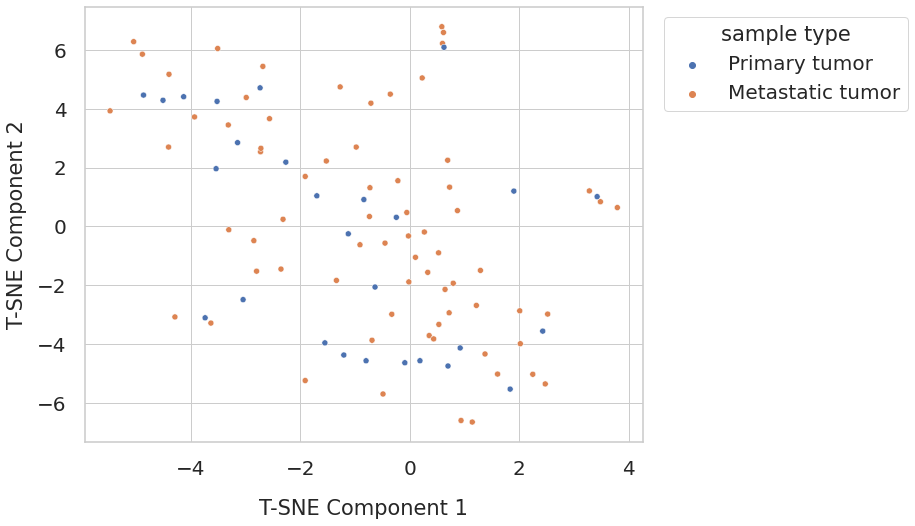

In [224]:

#get varables from previous cells




fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
feat = temp_info_sample['source_name_ch1']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'sample type', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




ONLY metastasis samples


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


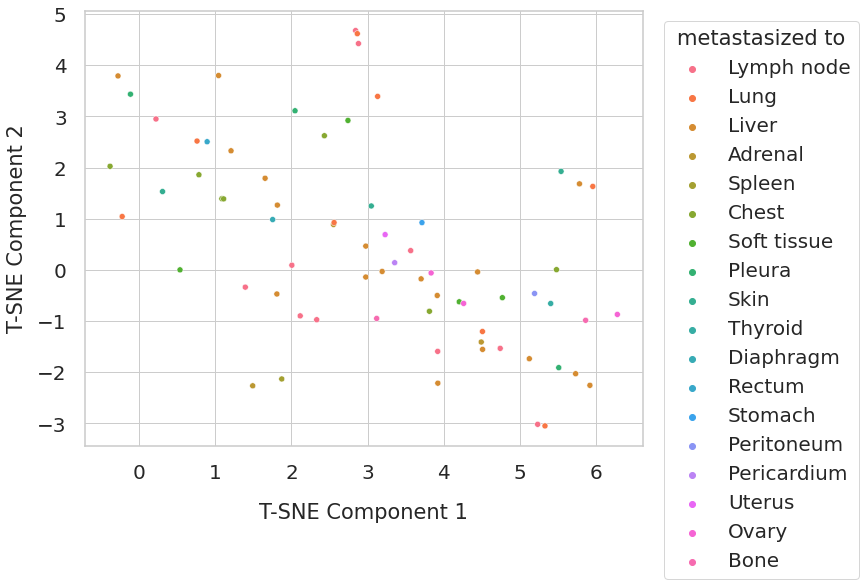

In [251]:

#get varables from previous cells

print("ONLY metastasis samples")
fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')][met_temp_info_sample['sample_id']].T
feat = met_temp_info_sample['characteristics_ch1.1.tissue']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'metastasized to', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




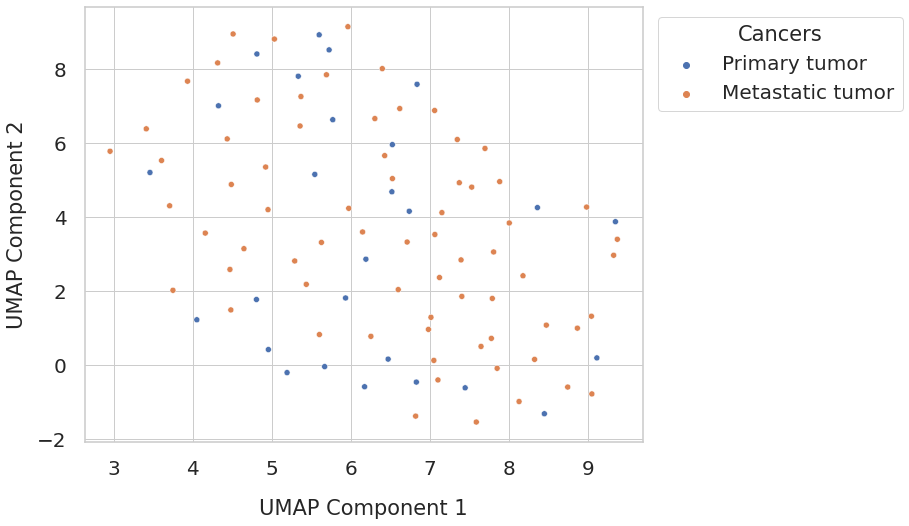

In [248]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
#WARNING careful the features variable here is different than the feat variable in T-sne subsection
features = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
#print("ALL integrins")
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1], hue = temp_info_sample['source_name_ch1'].tolist())
                #hue_order=cancers)
ax.legend(title = 'Cancers', fontsize=20, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_UMAP.jpg', dpi = 1000, bbox_inches='tight')

plt.show()

/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


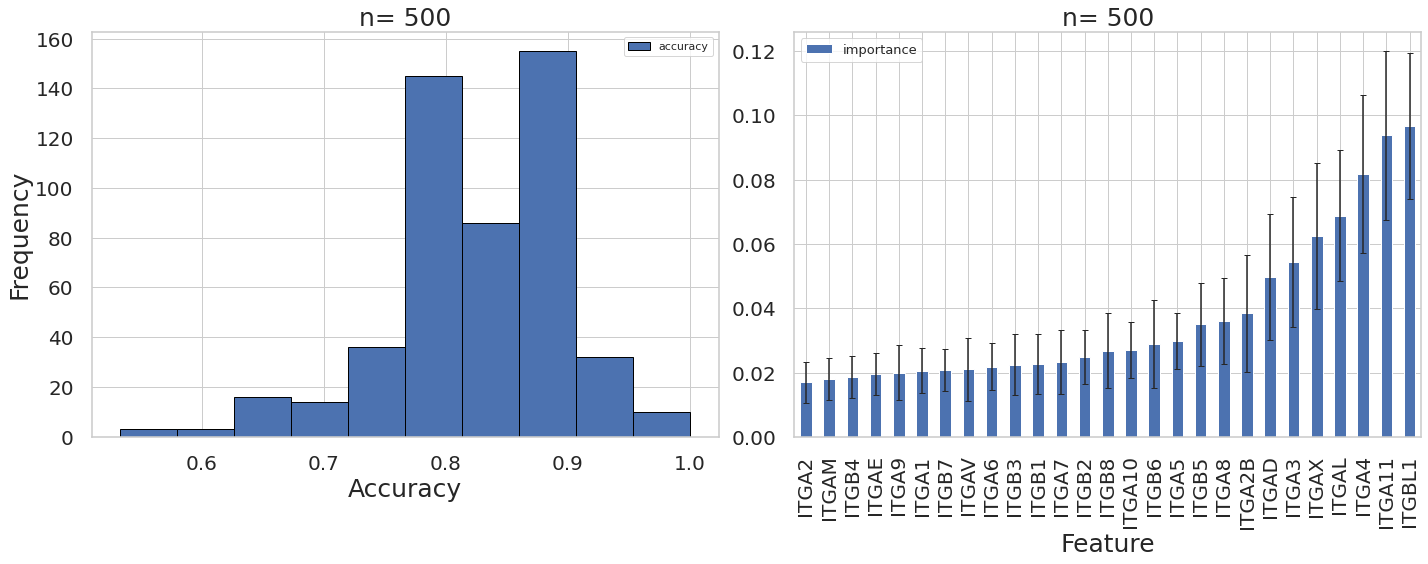

In [252]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, distinguishing primary and metastasis sample')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
    y = temp_info_sample['source_name_ch1']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


this is random forest, using only integrin expression, on only metastasis samples, met sites


/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


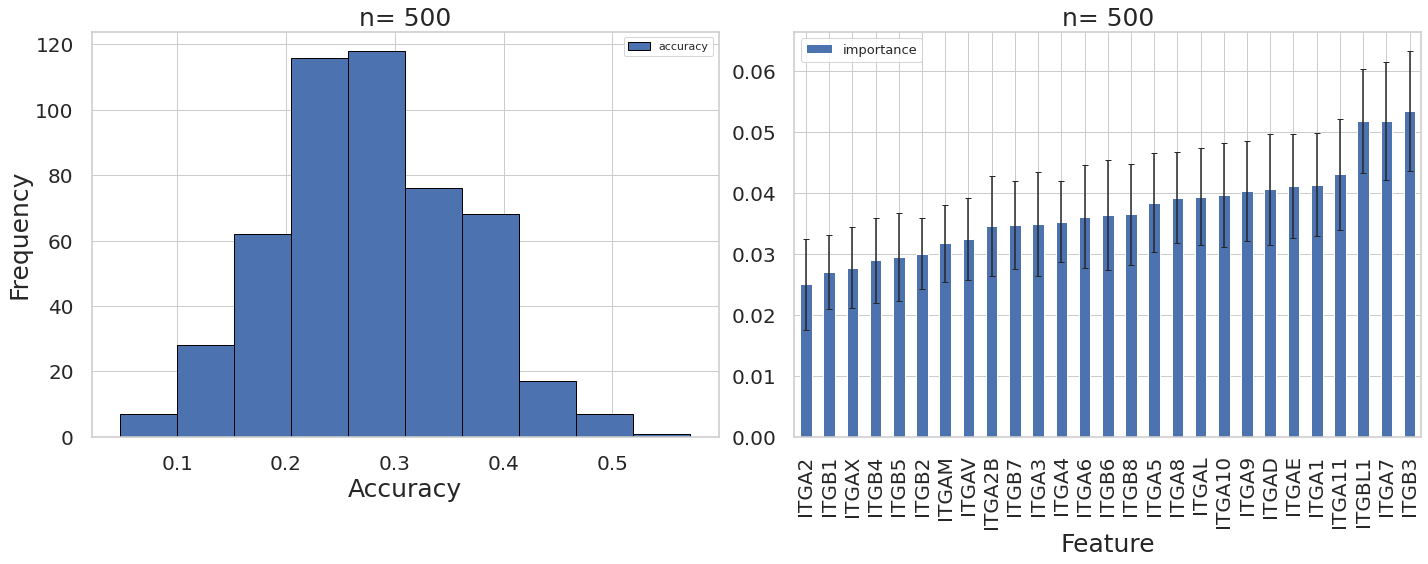

In [254]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, on only metastasis samples, met sites')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    y = met_temp_info_sample['characteristics_ch1.1.tissue']
    X = geo_expr[met_temp_info_sample['sample_id']].loc[itg_expr.index].T
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


In [267]:
corr_cutoff=0.5
met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]


Unnamed: 0
ITGA10    0.531770
ITGAV     0.579916
ITGB1     0.526303
ITGA5     0.542383
Name: HIF1A, dtype: float64

In [268]:
corr_cutoff=0.5
primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]


Unnamed: 0
ITGAV     0.849258
ITGA1     0.753765
ITGA8     0.565103
ITGB1     0.887992
ITGA5     0.796356
ITGBL1    0.501551
ITGB3     0.633347
Name: HIF1A, dtype: float64